# Streaming usecase

Requirements:
- Can access only instances as they arrive (not all data)
- Limited memory 
- Fast processing time
- Approximation algorithms: sketches

Streaming library for anomaly detection: https://pysad.readthedocs.io/en/latest/api.html#module-pysad.core

Paper: https://arxiv.org/pdf/2009.02572

In [1]:
import sys
sys.path.append('../src')
import evaluation_utils, data_utils

from pysad.models import xStream, LODA
from pysad.utils import ArrayStreamer
from pysad.transform.postprocessing import RunningAveragePostprocessor
from pysad.transform.preprocessing import InstanceUnitNormScaler
from pysad.transform.ensemble import AverageScoreEnsembler
from tqdm import tqdm
import numpy as np
import json
np.float = np.float64
np.int = np.int64

import warnings
# Ignore DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)


X shape: (1831, 21), y shape: (1831,)


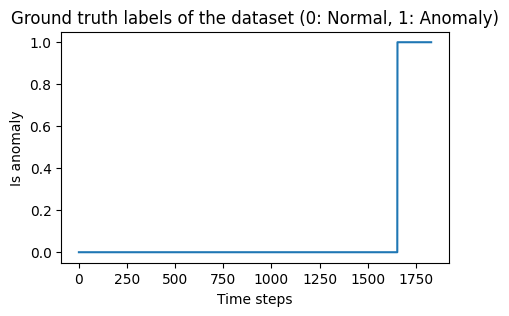

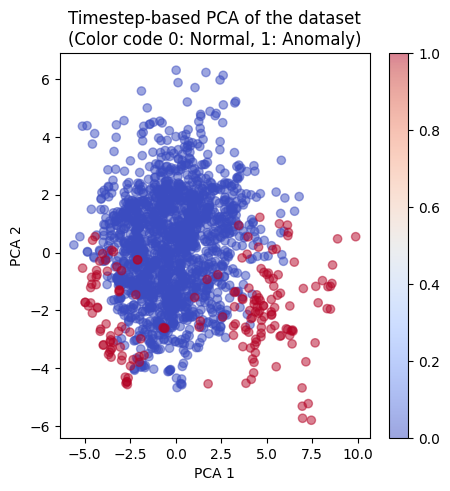

In [2]:
# Data loading
X_all, y_all = data_utils.get_data('../data/6_cardio.npz')
data_utils.plot_dataset(X_all, y_all)

In [3]:

iterator = ArrayStreamer(shuffle=False)  # Init streamer to simulate streaming data.

preprocessor = InstanceUnitNormScaler()  # Init normalizer.
postprocessor = RunningAveragePostprocessor(window_size=5)  # Init running average postprocessor.

models = [  # Models to be ensembled.
    xStream(),
    LODA()
]
ensembler = AverageScoreEnsembler()  # Ensembler module.

predicted_anomalies = []
for X, y in tqdm(iterator.iter(X_all, y_all)):  # Iterate over examples.
    model_scores = np.empty(len(models), dtype=np.float64)

    # Fit & Score via for each model.
    for i, model in enumerate(models):
        model.fit_partial(X)
        model_scores[i] = model.score_partial(X)

    score = ensembler.fit_transform_partial(model_scores)  # fit to ensembler model and get ensembled score.
    predicted_anomalies.append(score)
    
predicted_anomalies = np.array(predicted_anomalies).reshape(-1)

1831it [14:55,  2.05it/s]


# Evaluation

In [4]:
scores = evaluation_utils.run_evaluation(y_all, predicted_anomalies, do_point_adjustment=True)

In [5]:
# Pretty print results
print(json.dumps(scores, indent=4))

{
    "AUCROC": 0.6021560010985993,
    "AUCPR": 0.21270748338740472,
    "F1": 0.27096303728829885,
    "Precision": 0.2179930795847751,
    "Recall": 0.35795454545454547,
    "Adjusted AUCROC": 0.9993957703927492,
    "Adjusted AUCPR": 0.9943502824858758,
    "Adjusted F1": 0.9971621388753943,
    "Adjusted Precision": 0.9943502824858758,
    "Adjusted Recall": 1.0
}


In [6]:
data_utils.save_results(f"results/pysad LODA xStream.npz", scores)

Results saved to results/pysad LODA xStream.npz
